In [19]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [20]:
df = pd.read_excel('./dataset.xls')

In [21]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [22]:
df.shape

(7800, 9)

In [23]:
df.isna().sum()

Customer                0
Agent                   0
SalesAgentEmailID       0
ContactEmailID          0
Stage                   0
Product                 0
Close_Value          1208
Created Date            0
Close Date              0
dtype: int64

In [24]:
products = df.Product.unique()
products

array(['GTX Plus Basic', 'MG Special', 'MG Advanced', 'GTX Basic',
       'GTXPro', 'GTX Plus Pro', 'GTK 500'], dtype=object)

In [25]:

for product in products:
    mean = df[df.Product == product].Close_Value.mean()
    df.loc[df[(df.Product == product) & (df.Close_Value.isna())].index, "Close_Value"] = mean
    
df.isna().sum()

Customer             0
Agent                0
SalesAgentEmailID    0
ContactEmailID       0
Stage                0
Product              0
Close_Value          0
Created Date         0
Close Date           0
dtype: int64

### count in progress contracts:


In [26]:
df.Stage.value_counts()

Won            3738
In Progress    2089
Lost           1973
Name: Stage, dtype: int64

### predict in progress:


In [114]:
new_df = df.copy()
# new_df = new_df[df.Stage != "In Progress"]
one_hot_products = pd.get_dummies(new_df.Product)

new_df["Created Date"] = new_df["Created Date"].apply(lambda x: (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
new_df["Close Date"] = new_df["Close Date"].apply(lambda x: (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
new_df = new_df.join(one_hot_products)
new_df.drop("Product", axis=1, inplace=True)
new_df.drop(["Customer", "SalesAgentEmailID", "ContactEmailID", "Agent"], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(new_df.drop("Stage", axis=1), new_df.Stage)
model = RandomForestClassifier()
model.fit(new_df[new_df['Stage']!='In Progress'].drop("Stage", axis=1),new_df[new_df['Stage']!='In Progress'].Stage)

/tmp/ipykernel_35318/2382442731.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  new_df["Created Date"] = new_df["Created Date"].apply(lambda x: (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
/tmp/ipykernel_35318/2382442731.py:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  new_df["Close Date"] = new_df["Close Date"].apply(lambda x: (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))


RandomForestClassifier()

In [28]:
model.predict(new_df[new_df.Stage == "In Progress"].drop("Stage", axis=1))

array(['Lost', 'Won', 'Won', ..., 'Lost', 'Lost', 'Lost'], dtype=object)

In [29]:
df.loc[df[df.Stage == "In Progress"].index, "Stage"] = model.predict(new_df[new_df.Stage == "In Progress"].drop("Stage", axis=1))


In [30]:
df.Stage.value_counts()

Won     4225
Lost    3575
Name: Stage, dtype: int64

## customers:


### customers with most amount of money payed

<AxesSubplot:ylabel='Customer'>

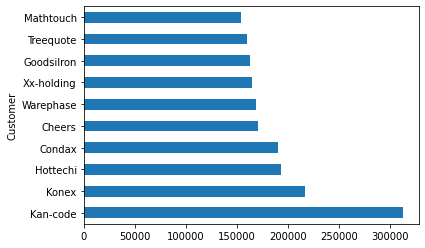

In [59]:
df[df.Stage == "Won"].groupby('Customer').sum()[['Close_Value']].sort_values(by='Close_Value', ascending=False).head(10).Close_Value.plot.barh()

### add some columns

In [86]:
customers = df.Customer
for customer in customers :
    sub_df = df[df.Customer == customer]
    df.loc[sub_df.index,'customer_won_rate'] = len(sub_df[sub_df.Stage == "Won"])/len(sub_df)
    df.loc[sub_df.index,'customer_lost_rate'] = len(sub_df[sub_df.Stage == "Lost"])/len(sub_df)

In [87]:
agents = df.Agent
for agent in agents :
    sub_df = df[df.Agent == agent]
    df.loc[sub_df.index,'agent_won_rate'] = len(sub_df[sub_df.Stage == "Won"])/len(sub_df)
    df.loc[sub_df.index,'agent_lost_rate'] = len(sub_df[sub_df.Stage == "Lost"])/len(sub_df)

### customers with most rate of wins

<AxesSubplot:ylabel='Customer'>

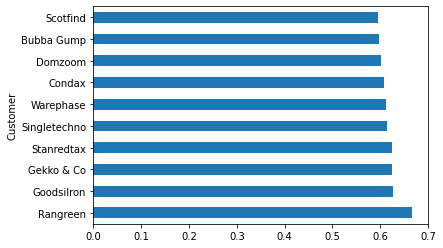

In [99]:
df.drop_duplicates(subset=['Customer']).groupby('Customer').mean().sort_values(by='customer_won_rate', ascending=False).head(10).customer_won_rate.plot.barh()

### customers with most rate of lost

<AxesSubplot:ylabel='Customer'>

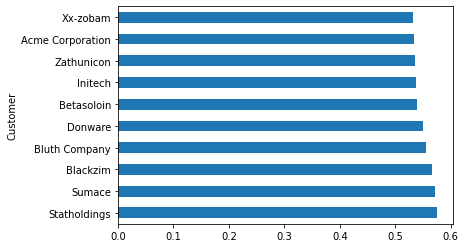

In [100]:
df.drop_duplicates(subset=['Customer']).groupby('Customer').mean().sort_values(by='customer_lost_rate', ascending=False).head(10).customer_lost_rate.plot.barh()

### agents with most rate of won

<AxesSubplot:ylabel='Agent'>

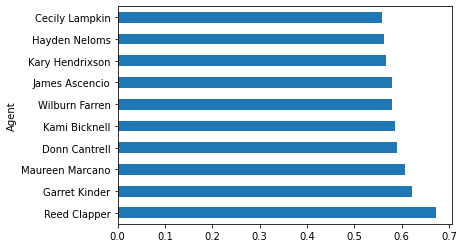

In [101]:
df.drop_duplicates(subset=['Agent']).groupby('Agent').mean().sort_values(by='agent_won_rate', ascending=False).head(10).agent_won_rate.plot.barh()

### agents with most amount of lost

<AxesSubplot:ylabel='Agent'>

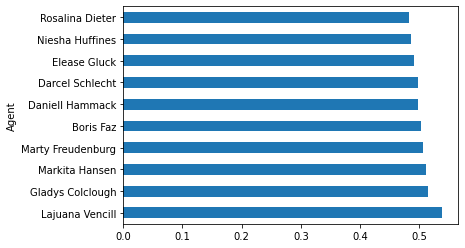

In [103]:
df.drop_duplicates(subset=['Agent']).groupby('Agent').mean().sort_values(by='agent_lost_rate', ascending=False).head(10).agent_lost_rate.plot.barh()

### product with most number of won


<AxesSubplot:>

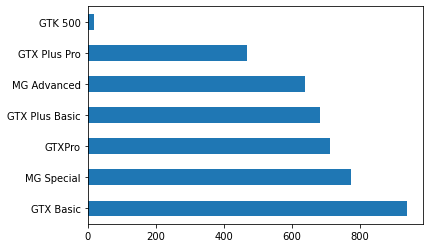

In [112]:
df[df.Stage == "Won"].Product.value_counts().plot.barh()

### product with most number of lost


<AxesSubplot:>

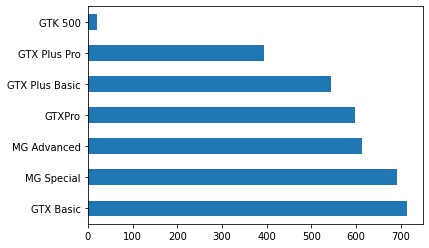

In [113]:
df[df.Stage == "Lost"].Product.value_counts().plot.barh()